<a href="https://colab.research.google.com/github/jjlintol1/trump-clinton-tweets-classifier/blob/main/trump_vs_clinton_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Tweets as from Donald Trump or Hillary Clinton

In this notebook, I will run some experiments to find a model architecture which is most effective at classifying tweets as from Donald Trump or Hillary Clinton prior to the 2016 presidential election.

In [ ]:
!nvidia-smi

Sun Dec 11 01:15:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |      0MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Make necessary imports
import tensorflow as tf
import numpy as np

In [ ]:
# Load and import helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-12-11 01:16:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-11 01:16:04 (93.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



## Load in data - Trump vs. Clinton Tweets

The dataset we are using is from Kaggle: https://www.kaggle.com/datasets/benhamner/clinton-trump-tweets

It contains around 6000 tweets from Donald Trump and Hillary Clinton before the 2016 election.

In [ ]:
# Upload the csv file via Google Colab
from google.colab import files
files.upload()

Saving archive (1).zip to archive (1) (1).zip


{'archive (1).zip': b'PK\x03\x04-\x00\x00\x00\x08\x00\xc4\xb13O\x16\xae\xf7L\xff\xff\xff\xff\xff\xff\xff\xff\n\x00\x14\x00tweets.csv\x01\x00\x10\x00\x8e\xbeN\x00\x00\x00\x00\x00 \xc4\x0e\x00\x00\x00\x00\x00\xec\xbd\xdbr\xdb\xc8\x96(\xf8\xee\xafH\xab\xba[\xdd\xd1\x14\x85\xcc\xc4\x95==U\x94,\xebb\xebbI\xb6,w\xecP\x80$H\xc2"\x01\x1a\x00EQ;*\xa2\x9e\xce\xd3<\x9d\xd9\x0f\xd3\x11\xa7_\xe7\xfd\xc4|B\xffI}\xc9\xac\x95\x00\x88;ER\x94\xeb\xb2U\xe5*Kd\x02H\xe4\xba\xdf\xedN\xado:\x9d\x81U\x0b\xac\xfb\xa0f\xfb7\x9e\x15L,+\xa8\xb9\x9e\xdd\xb3\x1dspc\x8e\x83\xbe\xeb\xd5\x02{h\xd5l\x07\xbe\x1f\r\xa67\x81{\xe3\xb7=\xcbrn\x1c3\xffy`\x06c\xff\x06\xee\x9c\xfet\xec[\x9e\xf8\xcc\xbf\xf96v\x03+ZV\x1b\x98N\xaf\x16=\xf3\xa6\xed\x8e\x9d\xa0\xd65\xef\xe0\xe1\xb0$\xfcu\xe0:=;\x18w,X\x1b\x84?\x8c\x06f\xdb\xc2\xbb\x85?t\xc7\x83A\xb8\x8f\xf0\xf7\xd4\x8f\xc1t\x14\xff(\xee\xe6M\xe1\xefN\xee\xa3\xd9oN`\xda\x8e\xd5\xb9\x99\xd8A\xdfv\xa2\x8f\xcd \xf0\xec\xd68\xb0\xfc\xe8\x83\x16\\\xd5\xb1\x9d\x1e\xfcp_\xf3\xdd\xb1\x07\x9

In [ ]:
# I renamed the folder manually to "data.zip" to make easier to unzip functionally
unzip_data("data.zip")

Now our tweets.csv file is available in the root directory.

In [ ]:
# Read in the data
import pandas as pd

tweets = pd.read_csv("tweets.csv")
tweets.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [ ]:
len(tweets), tweets.shape

(6444, (6444, 28))

In [ ]:
# Drop all tweets that are retweets - we just want to work with original tweets
tweets.drop(tweets[tweets["is_retweet"] == True].index, inplace=True)

In [ ]:
# Check to make sure we dropped all retweets
tweets["is_retweet"].value_counts()

False    5722
Name: is_retweet, dtype: int64

In [ ]:
len(tweets)

5722

## Become one with our data

Let's get to know the relevant data a little more.

In [ ]:
# Check to see how many tweets come from each
tweets["handle"].value_counts()

realDonaldTrump    3093
HillaryClinton     2629
Name: handle, dtype: int64

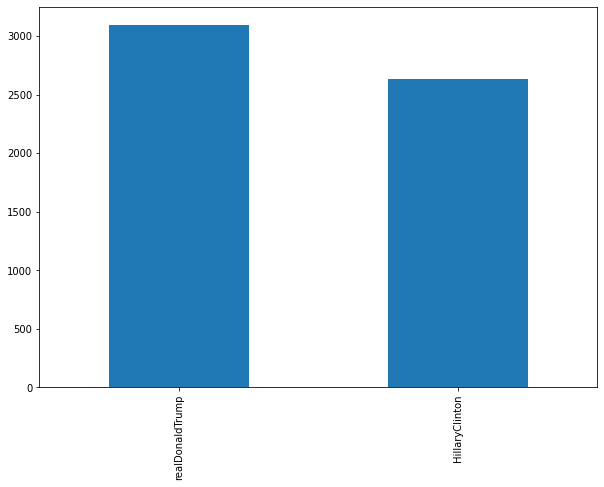

In [ ]:
tweets["handle"].value_counts().plot(kind="bar", figsize=(10, 7))

In [ ]:
# Let's take a look at some of the tweets belonging to each
import random

random_index = random.randint(0, len(tweets)-5) # We want to get a random sequence of 5 tweets (subtract 5 to make sure we don't go out of range)

for row in tweets[random_index:random_index+5].itertuples(): # Let's pretty print 5 consecutive random tweets from the dataset
  _, _, handle, tweet = row[:4]
  print(f"Handle: {handle}")
  print(f"Tweet:\n{tweet}")
  print("\n---\n")

Handle: HillaryClinton
Tweet:
In Rio, Olympic fencer Ibtihaj Muhammad became the first American Muslim athlete to compete while wearing a hijab. https://t.co/OrRSHnH2Ra

---

Handle: realDonaldTrump
Tweet:
My economic policy speech will be carried live at 12:15 P.M. Enjoy!

---

Handle: HillaryClinton
Tweet:
When you're comparing Hillary's and Trump's economic plans, there are two numbers you need to know. https://t.co/GdanBYOMUz

---

Handle: HillaryClinton
Tweet:
"I don't know another businessman that brags about his bankruptcies." —@WarrenBuffett on Trump: https://t.co/Jx2p1D6UAd

---

Handle: realDonaldTrump
Tweet:
Join me in Fayetteville, North Carolina tomorrow evening at 6pm. Tickets now available at: https://t.co/Z80d4MYIg8

---



## Get our data ready for modeling

Before we move forward, we need to create a new column in the DataFrame with numerically-encoded labels (0 for Hillary and 1 for Trump)

In [ ]:
# Numerically encode the data
tweets["handle_target"] = tweets["handle"].apply(lambda x: 1 if x == "realDonaldTrump" else 0)
tweets.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities,handle_target
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...,0
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...,0
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN,0
5,780893126605037568,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...,False,NaN,2016-09-27T22:13:24,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,http://twitter.com/download/iphone,True,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN,1
6,780883582051123200,HillaryClinton,This election is too important to sit out. Go ...,False,NaN,2016-09-27T21:35:28,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN,0


In [ ]:
# Constant of labels we can use to visualize predictions later
handle_labels = ["HillaryClinton", "realDonaldTrump"]

Let's check to make sure the numerical encoding is identical to the actual labels.

In [ ]:
tweets["handle_target"].value_counts()

1    3093
0    2629
Name: handle_target, dtype: int64

In [ ]:
tweets["handle"].value_counts()

realDonaldTrump    3093
HillaryClinton     2629
Name: handle, dtype: int64

Looks good. Let's split the data

In [ ]:
# Let's extract the tweets and labels
from sklearn.model_selection import train_test_split

all_tweets = tweets["text"].to_numpy()
labels = tweets["handle_target"].to_numpy()

all_tweets[:5], labels[:5]

(array(['The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG',
        "If we stand together, there's nothing we can't do. \n\nMake sure you're ready to vote: https://t.co/tTgeqxNqYm https://t.co/Q3Ymbb7UNy",
        "Both candidates were asked about how they'd confront racial injustice. Only one had a real answer. https://t.co/sjnEokckis",
        'Join me for a 3pm rally - tomorrow at the Mid-America Center in Council Bluffs, Iowa! Tickets:… https://t.co/dfzsbICiXc',
        "This election is too important to sit out. Go to https://t.co/tTgeqxNqYm and make sure you're registered. #NationalVoterRegistrationDay -H"],
       dtype=object), array([0, 0, 0, 1, 0]))

In [ ]:
# Split into train and validation
train_tweets, val_tweets, train_labels, val_labels = train_test_split(all_tweets, labels, test_size=0.2, random_state=42)
train_tweets.shape, train_labels.shape, val_tweets.shape, val_labels.shape

((4577,), (4577,), (1145,), (1145,))

## Convert our text data into numbers

We need to get our text data into numbers. We will do this through TensorFlow's TextVectorization (tokenizer) and Embedding layers.

### Tokenizer

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
# Find the longest tweet in the training tweets
np.max([len(i.split()) for i in train_tweets])

30

In [ ]:
max_vocab_length = 10000 # up to 10000 words in our vocab
max_token_length = 30 # longest tweet (see above cell output)

encoder = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int", # May play around with this later on
    output_sequence_length=max_token_length,
    standardize="lower" # NOTE: I specifically decided not to strip punctuation because Trump tweets often include exclamation points (a pattern we may want the model to learn)
)

encoder.adapt(train_tweets)

In [ ]:
# Tokenize a dummy tweet
sample_tweet = "I'm having a rally in Georgia. Be there!"

encoder([sample_tweet])

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[ 321,  627,    4,  331,    6,    1,   15, 2472,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
random_tweet = random.choice(train_tweets)
encoded = encoder([random_tweet])

print(f"Original tweet:\n{random_tweet}\n\n")
print(f"Vectorized:\n{encoded}")

Original tweet:
"@redneckgp: All you haters out there, STOP trashing the only candidate @realDonaldTrump that will put ALL OF YOU &amp; AMERICA FIRST  #trump"


Vectorized:
[[   1   34   12 2839   57 2471  176 5886    2   81  210   45   17   14
   198   34    7   12   47   51  116    1    0    0    0    0    0    0
     0    0]]


In [ ]:
vocab = encoder.get_vocabulary()

# Let's look at the most/least common words in the data
top_five = vocab[:5]
bottom_five = vocab[-5:]

print(f"Length of vocab: {len(vocab)}\n")
print(f"Most common words: {top_five}\n")
print(f"Least common words: {bottom_five}")

Length of vocab: 10000

Most common words: ['', '[UNK]', 'the', 'to', 'a']

Least common words: ['https://t.co/nfyovqph8v', 'https://t.co/nfjhuq1ypi', 'https://t.co/nfiydptppn', 'https://t.co/nepqayw1g5', 'https://t.co/nepnsdynzs']


### Embedding layer

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
embedding_layer = Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=max_token_length
)

## Modeling experiments

Now we have our data and tokenization/embedding layers ready. Let's try a few experiments to see how each works on this dataset (set up a backbone for how we want to continue)

We can try the following:

* Model 0: Naive Bayes Classifier (from sklearn - non-deep learning) baseline
* Model 1: Feed-forward neural network
* Model 2: LSTM layer
* Model 3: GRU layer
* Model 4: Bidirectional LSTM
* Model 5: Conv1D
* Model 6: TensorFlow Hub transfer learning experimentation

### Model 0 - Naive Bayes classifier (baseline)

We will baseline with a non-deep learning approach and see how that does on our data.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer # We will use Tf-Idf for the baseline in scikit-learn

In [ ]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_tweets, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_tweets, val_labels)
baseline_score

0.9222707423580786

In [ ]:
# Let's create a function to evaluate a few metrics for classification which we can reuse

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Returns a dictionary of accuracy, precision, recall and f1 for y_pred relative to y_true
  """
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  return {
      "accuracy": accuracy_score(y_true, y_pred),
      "precision": precision,
      "recall": recall,
      "f1-score": f1
  }

In [ ]:
baseline_preds = model_0.predict(val_tweets)
baseline_preds[:10]

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0])

In [ ]:
# Show precision, recall, and f1 for baseline
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 0.9222707423580786,
 'precision': 0.9222498268820397,
 'recall': 0.9222707423580786,
 'f1-score': 0.9222255175754528}

### Model 1: Feed-forward neural network

The NB classifier looks to have done pretty well on our validation data. Let's play with some neural networks to see if we can improve on this.

We'll start with a standard Dense network.

In [ ]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)

x = encoder(inputs)
x = embedding_layer(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [ ]:
LOG_DIR = "tensorboard_info"

In [ ]:
history_1 = model_1.fit(
    train_tweets,
    train_labels,
    epochs=10,
    validation_data=(val_tweets, val_labels),
    callbacks=[
        create_tensorboard_callback(
            LOG_DIR,
            "model_1"
        )
    ]
)

Saving TensorBoard log files to: tensorboard_info/model_1/20221211-011647
Epoch 1/10
144/144 [==============================] - 4s 7ms/step - loss: 0.6446 - accuracy: 0.6511 - val_loss: 0.5726 - val_accuracy: 0.8079
Epoch 2/10
144/144 [==============================] - 1s 6ms/step - loss: 0.4457 - accuracy: 0.9124 - val_loss: 0.3848 - val_accuracy: 0.9004
Epoch 3/10
144/144 [==============================] - 1s 8ms/step - loss: 0.2712 - accuracy: 0.9495 - val_loss: 0.2850 - val_accuracy: 0.9118
Epoch 4/10
144/144 [==============================] - 1s 7ms/step - loss: 0.1796 - accuracy: 0.9668 - val_loss: 0.2312 - val_accuracy: 0.9249
Epoch 5/10
144/144 [==============================] - 1s 7ms/step - loss: 0.1280 - accuracy: 0.9753 - val_loss: 0.2020 - val_accuracy: 0.9301
Epoch 6/10
144/144 [==============================] - 1s 5ms/step - loss: 0.0957 - accuracy: 0.9830 - val_loss: 0.1780 - val_accuracy: 0.9371
Epoch 7/10
144/144 [==============================] - 1s 8ms/step - loss: 

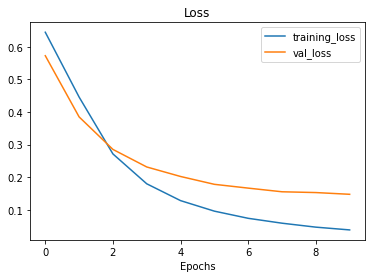

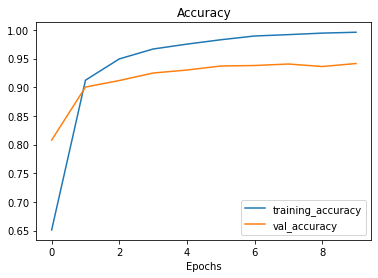

In [ ]:
# Function from helpers
plot_loss_curves(history_1)

In [ ]:
model_1_final = model_1.evaluate(val_tweets, val_labels)
model_1_final

36/36 [==============================] - 0s 3ms/step - loss: 0.1474 - accuracy: 0.9415


[0.14737045764923096, 0.9414846897125244]

In [ ]:
# Let's make a predict function to make predictions with a model and format them as the numerically-encoded labels
def make_predictions(model, tweets=val_tweets):
  """
  Makes predictions on input tweets with input model and returns them formatted as 0 or 1
  """
  pred_probs = model.predict(tweets)
  preds = tf.squeeze(tf.round(pred_probs))
  return preds

In [ ]:
model_1_preds = make_predictions(model_1)

36/36 [==============================] - 0s 2ms/step


In [ ]:
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 1., 1., 0., 1., 0.], dtype=float32)>

In [ ]:
# Let's get the other scores for model 1
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.9414847161572052,
 'precision': 0.9416547764838686,
 'recall': 0.9414847161572052,
 'f1-score': 0.9414062489667233}

### Model 2: Single LSTM layer

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)

x = encoder(inputs)
x = embedding_layer(x)
x = layers.LSTM(32, activation="tanh")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________

In [ ]:
history_2 = model_2.fit(
    train_tweets,
    train_labels,
    epochs=10,
    validation_data=(val_tweets, val_labels),
    callbacks=[
        create_tensorboard_callback(
            LOG_DIR,
            "model_2"
        )
    ]
)

Saving TensorBoard log files to: tensorboard_info/model_2/20221211-011702
Epoch 1/10
144/144 [==============================] - 7s 13ms/step - loss: 0.1481 - accuracy: 0.9633 - val_loss: 0.2983 - val_accuracy: 0.9284
Epoch 2/10
144/144 [==============================] - 1s 8ms/step - loss: 0.0302 - accuracy: 0.9952 - val_loss: 0.3678 - val_accuracy: 0.9249
Epoch 3/10
144/144 [==============================] - 1s 8ms/step - loss: 0.0138 - accuracy: 0.9980 - val_loss: 0.3293 - val_accuracy: 0.9362
Epoch 4/10
144/144 [==============================] - 1s 9ms/step - loss: 0.0082 - accuracy: 0.9991 - val_loss: 0.3565 - val_accuracy: 0.9362
Epoch 5/10
144/144 [==============================] - 1s 8ms/step - loss: 0.0074 - accuracy: 0.9991 - val_loss: 0.3757 - val_accuracy: 0.9354
Epoch 6/10
144/144 [==============================] - 1s 8ms/step - loss: 0.0044 - accuracy: 0.9996 - val_loss: 0.3907 - val_accuracy: 0.9362
Epoch 7/10
144/144 [==============================] - 1s 8ms/step - loss:

In [ ]:
model_2_final = model_2.evaluate(val_tweets, val_labels)
model_2_final

36/36 [==============================] - 0s 5ms/step - loss: 0.3744 - accuracy: 0.9336


[0.3744036853313446, 0.9336244463920593]

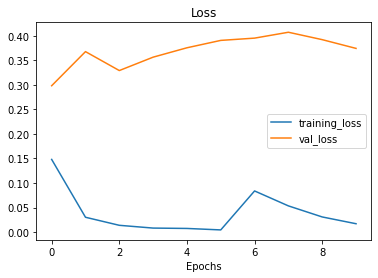

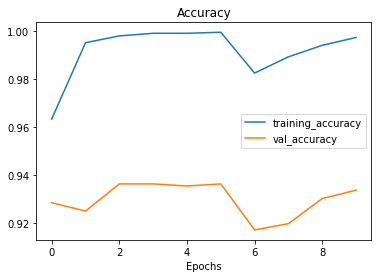

In [ ]:
plot_loss_curves(history_2)

Based on the loss curves, it looks like the LSTM layer caused the model to overfit on our training data.

In [ ]:
model_2_preds = make_predictions(model_2)

36/36 [==============================] - 1s 5ms/step


In [ ]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.9336244541484716,
 'precision': 0.9336548241461262,
 'recall': 0.9336244541484716,
 'f1-score': 0.933567723087433}

### Model 3: GRU

After the first two experiments, both deep learning models are beating the baseline. However, the feed-forward NN is in the lead. Let's try GRU.

In [ ]:
inputs = layers.Input(shape=(1, ), dtype=tf.string)

x = encoder(inputs)
x = embedding_layer(x)
x = layers.GRU(32)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 32)                15552     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,295,585
Trainable params: 1,295,585
Non-trainable params: 0
_________________________________________________

In [ ]:
history_3 = model_3.fit(
    train_tweets,
    train_labels,
    epochs=10,
    validation_data=(val_tweets, val_labels),
    callbacks=[
        create_tensorboard_callback(
            LOG_DIR,
            "model_3"
        )
    ]
)

Saving TensorBoard log files to: tensorboard_info/model_3/20221211-011726
Epoch 1/10
144/144 [==============================] - 3s 10ms/step - loss: 0.2356 - accuracy: 0.8748 - val_loss: 0.3158 - val_accuracy: 0.9336
Epoch 2/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0205 - accuracy: 0.9969 - val_loss: 0.3465 - val_accuracy: 0.9336
Epoch 3/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0295 - accuracy: 0.9945 - val_loss: 0.5242 - val_accuracy: 0.8847
Epoch 4/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 0.4433 - val_accuracy: 0.9179
Epoch 5/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0160 - accuracy: 0.9974 - val_loss: 0.3914 - val_accuracy: 0.9301
Epoch 6/10
144/144 [==============================] - 1s 7ms/step - loss: 0.0339 - accuracy: 0.9941 - val_loss: 0.2976 - val_accuracy: 0.9249
Epoch 7/10
144/144 [==============================] - 1s 7ms/step - loss:

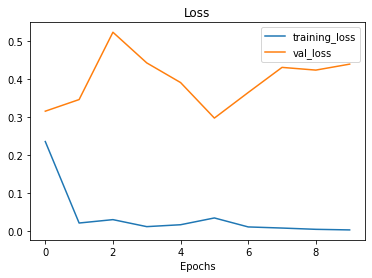

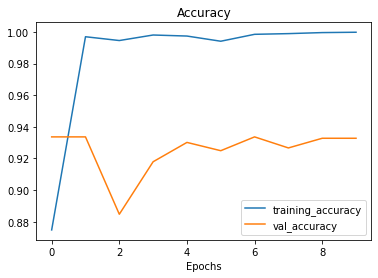

In [ ]:
plot_loss_curves(history_3)

In [ ]:
model_3_final = model_3.evaluate(val_tweets, val_labels)
model_3_final

36/36 [==============================] - 0s 4ms/step - loss: 0.4400 - accuracy: 0.9328


[0.4400314688682556, 0.9327511191368103]

In [ ]:
model_3_preds = make_predictions(model_3)

36/36 [==============================] - 0s 3ms/step


In [ ]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 0.9327510917030568,
 'precision': 0.9340344831072915,
 'recall': 0.9327510917030568,
 'f1-score': 0.9325034339688834}

### Model 4: Bidirectional LSTM

Model 1 still is in the lead. Let's give bidirectional LSTM a shot.

In [ ]:
inputs = layers.Input(shape=(1, ), dtype=tf.string)

x = encoder(inputs)
x = embedding_layer(x)
x = layers.Bidirectional(layers.LSTM(32))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs)

model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               41216     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,321,281
Trainable params: 1,321,281
Non-tra

In [ ]:
history_4 = model_4.fit(
    train_tweets,
    train_labels,
    epochs=10,
    validation_data=(val_tweets, val_labels),
    callbacks=[
        create_tensorboard_callback(
            LOG_DIR,
            "model_4"
        )
    ]
)

Saving TensorBoard log files to: tensorboard_info/model_4/20221211-011750
Epoch 1/10
144/144 [==============================] - 6s 18ms/step - loss: 0.0625 - accuracy: 0.9956 - val_loss: 0.2558 - val_accuracy: 0.9328
Epoch 2/10
144/144 [==============================] - 2s 12ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.2823 - val_accuracy: 0.9362
Epoch 3/10
144/144 [==============================] - 2s 15ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.2963 - val_accuracy: 0.9345
Epoch 4/10
144/144 [==============================] - 2s 11ms/step - loss: 6.4932e-04 - accuracy: 1.0000 - val_loss: 0.3315 - val_accuracy: 0.9249
Epoch 5/10
144/144 [==============================] - 2s 11ms/step - loss: 2.9812e-04 - accuracy: 1.0000 - val_loss: 0.3473 - val_accuracy: 0.9249
Epoch 6/10
144/144 [==============================] - 1s 10ms/step - loss: 2.1257e-04 - accuracy: 1.0000 - val_loss: 0.3605 - val_accuracy: 0.9249
Epoch 7/10
144/144 [==============================] - 1s

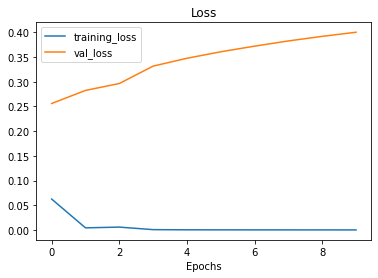

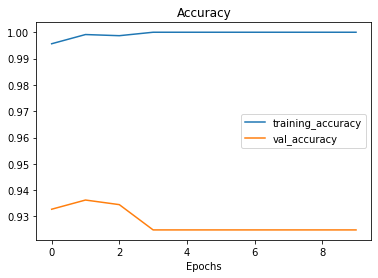

In [ ]:
plot_loss_curves(history_4)

In [ ]:
model_4_final = model_4.evaluate(val_tweets, val_labels)
model_4_final

36/36 [==============================] - 0s 5ms/step - loss: 0.4000 - accuracy: 0.9249


[0.39997267723083496, 0.9248908162117004]

In [ ]:
model_4_preds = make_predictions(model_4)

36/36 [==============================] - 1s 4ms/step


In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 0.9248908296943231,
 'precision': 0.9249193652670871,
 'recall': 0.9248908296943231,
 'f1-score': 0.9249022586379335}

### Model 5: Conv1D

In [ ]:
inputs = layers.Input(shape=(1, ), dtype=tf.string)

x = encoder(inputs)
x = embedding_layer(x)
x = layers.Conv1D(filters=64, kernel_size=5, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 30)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 30, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [ ]:
history_5 = model_5.fit(
    train_tweets,
    train_labels,
    epochs=10,
    validation_data=(val_tweets, val_labels),
    callbacks=[
        create_tensorboard_callback(
            LOG_DIR,
            "model_5"
        )
    ]
)

Saving TensorBoard log files to: tensorboard_info/model_5/20221211-011812
Epoch 1/10
144/144 [==============================] - 6s 8ms/step - loss: 0.0798 - accuracy: 0.9897 - val_loss: 0.1439 - val_accuracy: 0.9354
Epoch 2/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0133 - accuracy: 0.9987 - val_loss: 0.1471 - val_accuracy: 0.9336
Epoch 3/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0081 - accuracy: 0.9989 - val_loss: 0.1604 - val_accuracy: 0.9293
Epoch 4/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0058 - accuracy: 0.9991 - val_loss: 0.1650 - val_accuracy: 0.9362
Epoch 5/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.1711 - val_accuracy: 0.9397
Epoch 6/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.1804 - val_accuracy: 0.9371
Epoch 7/10
144/144 [==============================] - 1s 6ms/step - loss: 

This model came out of the gate strong but fell off as training went on. Maybe try a dropout layer layer on?

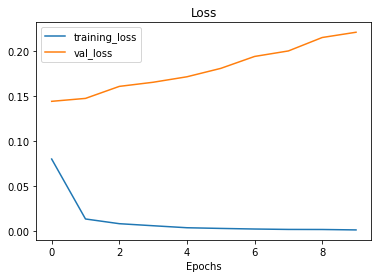

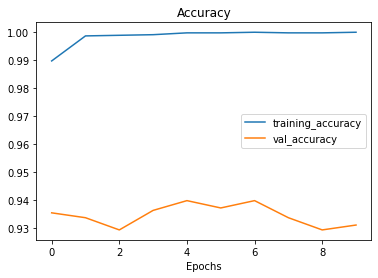

In [ ]:
plot_loss_curves(history_5)

In [ ]:
model_5_final = model_5.evaluate(val_tweets, val_labels)
model_5_final

36/36 [==============================] - 0s 4ms/step - loss: 0.2205 - accuracy: 0.9310


[0.2205321043729782, 0.9310043454170227]

In [ ]:
model_5_preds = make_predictions(model_5)

model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

36/36 [==============================] - 0s 3ms/step


{'accuracy': 0.9310043668122271,
 'precision': 0.9310483971585535,
 'recall': 0.9310043668122271,
 'f1-score': 0.931019953402698}

## Model 6: Transfer Learning

For this part, we will build a transfer learning model and fine-tune the Universal Sentence Encoder from TensorFlow Hub. Can we beat our feed-forward network?

In [ ]:
import tensorflow_hub as hub

In [ ]:
# Instantiate the layer
sentence_encoder = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="USE"
)

In [ ]:
model_6 = tf.keras.Sequential([
    sentence_encoder,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
initial_epochs = 5

history_6 = model_6.fit(
    train_tweets,
    train_labels,
    epochs=initial_epochs,
    validation_data=(val_tweets, val_labels),
    callbacks=[
        create_tensorboard_callback(
            LOG_DIR,
            "model_6"
        )
    ]
)

Saving TensorBoard log files to: tensorboard_info/model_6/20221211-011857
Epoch 1/5
144/144 [==============================] - 7s 24ms/step - loss: 0.5228 - accuracy: 0.7758 - val_loss: 0.4188 - val_accuracy: 0.8201
Epoch 2/5
144/144 [==============================] - 2s 16ms/step - loss: 0.3615 - accuracy: 0.8479 - val_loss: 0.3734 - val_accuracy: 0.8341
Epoch 3/5
144/144 [==============================] - 2s 17ms/step - loss: 0.3261 - accuracy: 0.8643 - val_loss: 0.3534 - val_accuracy: 0.8524
Epoch 4/5
144/144 [==============================] - 2s 17ms/step - loss: 0.3083 - accuracy: 0.8676 - val_loss: 0.3492 - val_accuracy: 0.8559
Epoch 5/5
144/144 [==============================] - 2s 15ms/step - loss: 0.2958 - accuracy: 0.8752 - val_loss: 0.3433 - val_accuracy: 0.8568


Not a great start. Let's check our results and see if fine-tuning will improve the model.

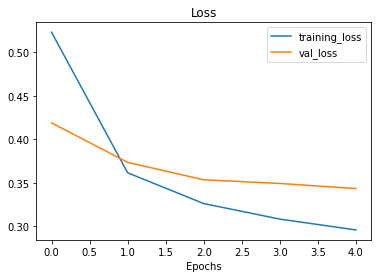

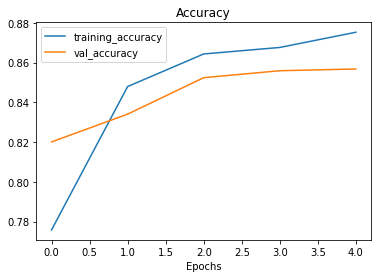

In [ ]:
plot_loss_curves(history_6)

In [ ]:
model_6_feature_extract_final = model_6.evaluate(val_tweets, val_labels)
model_6_feature_extract_final

36/36 [==============================] - 0s 12ms/step - loss: 0.3433 - accuracy: 0.8568


[0.3433261513710022, 0.8567685484886169]

In [ ]:
feature_extract_preds = make_predictions(model_6)
feature_extract_results = calculate_results(val_labels, feature_extract_preds)
feature_extract_results

36/36 [==============================] - 1s 11ms/step


{'accuracy': 0.856768558951965,
 'precision': 0.856867570712783,
 'recall': 0.856768558951965,
 'f1-score': 0.8564368511218399}

### Fine-tune the model

Let's unfreeze the USE and see if we can inprove results by giving it 10 more epochs

In [ ]:
for layer in model_6.layers:
  print(layer.name, layer.trainable)

USE False
dense_5 True
dense_6 True


In [ ]:
model_6.layers[0].trainable = True

In [ ]:
for layer in model_6.layers:
  print(layer.name, layer.trainable)

USE True
dense_5 True
dense_6 True


In [ ]:
# Recompile
model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 256,830,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
total_epochs = initial_epochs + 10

history_fine_tuned = model_6.fit(
    train_tweets,
    train_labels,
    epochs=total_epochs,
    validation_data=(val_tweets, val_labels),
    callbacks=[
        create_tensorboard_callback(
            LOG_DIR,
            "model_6_fine_tuned"
        )
    ],
    initial_epoch=history_6.epoch[-1]
)

Saving TensorBoard log files to: tensorboard_info/model_6_fine_tuned/20221211-011922
Epoch 5/15
144/144 [==============================] - 27s 160ms/step - loss: 0.2548 - accuracy: 0.8943 - val_loss: 0.3109 - val_accuracy: 0.8856
Epoch 6/15
144/144 [==============================] - 23s 156ms/step - loss: 0.0427 - accuracy: 0.9858 - val_loss: 0.2718 - val_accuracy: 0.8943
Epoch 7/15
144/144 [==============================] - 22s 156ms/step - loss: 0.0057 - accuracy: 0.9993 - val_loss: 0.2327 - val_accuracy: 0.9144
Epoch 8/15
144/144 [==============================] - 23s 157ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.2358 - val_accuracy: 0.9223
Epoch 9/15
144/144 [==============================] - 23s 158ms/step - loss: 5.0599e-04 - accuracy: 1.0000 - val_loss: 0.2472 - val_accuracy: 0.9205
Epoch 10/15
144/144 [==============================] - 22s 155ms/step - loss: 2.9519e-04 - accuracy: 1.0000 - val_loss: 0.2402 - val_accuracy: 0.9223
Epoch 11/15
144/144 [===============

In [ ]:
fine_tune_final = model_6.evaluate(val_tweets, val_labels)
fine_tune_final

36/36 [==============================] - 1s 29ms/step - loss: 0.2540 - accuracy: 0.9258


[0.25404229760169983, 0.9257642030715942]

In [ ]:
fine_tune_preds = make_predictions(model_6)
fine_tune_results = calculate_results(val_labels, fine_tune_preds)
fine_tune_results

36/36 [==============================] - 1s 25ms/step


{'accuracy': 0.925764192139738,
 'precision': 0.9259087457065432,
 'recall': 0.925764192139738,
 'f1-score': 0.9258017037156859}

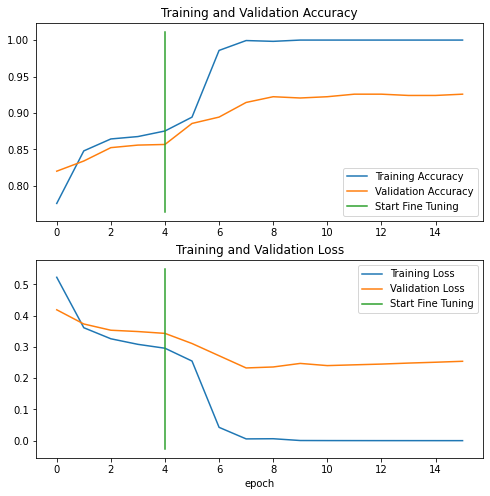

In [ ]:
compare_historys(history_6, history_fine_tuned)

## Compare our experiments

Let's look at the results from all of our experiments.

In [ ]:
all_results = pd.DataFrame({
    "baseline": baseline_results,
    "model_1": model_1_results,
    "model_2": model_2_results,
    "model_3": model_3_results,
    "model_4": model_4_results,
    "model_5": model_5_results,
    "model_6": fine_tune_results
}).transpose()

all_results

,accuracy,precision,recall,f1-score
baseline,0.922271,0.922250,0.922271,0.922226
model_1,0.941485,0.941655,0.941485,0.941406
model_2,0.933624,0.933655,0.933624,0.933568
model_3,0.932751,0.934034,0.932751,0.932503
model_4,0.924891,0.924919,0.924891,0.924902
model_5,0.931004,0.931048,0.931004,0.931020
model_6,0.925764,0.925909,0.925764,0.925802


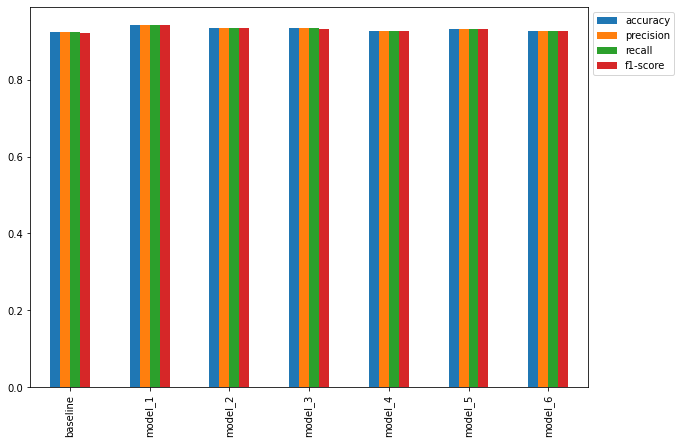

In [ ]:
all_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

### Dive deeper into results

Based on this, model 1 was clearly the best model. Let's loook into its results a bit more.

In [ ]:
from helper_functions import make_confusion_matrix

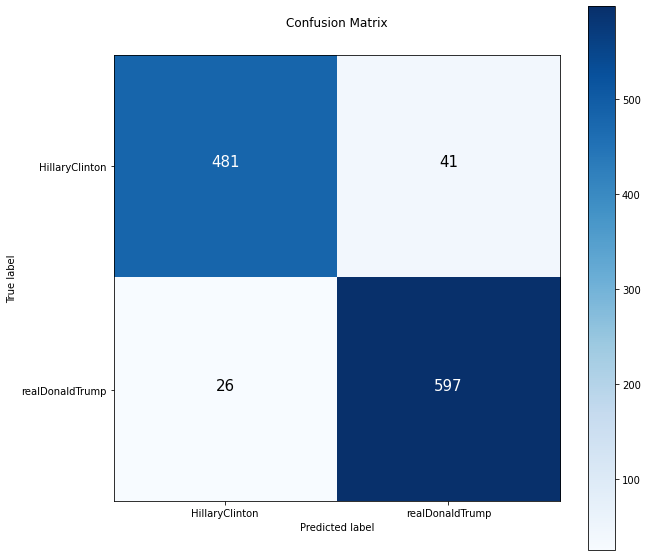

In [ ]:
make_confusion_matrix(val_labels, model_1_preds, classes=handle_labels)

Let's now check out where the model was most wrong.

In [ ]:
model_1_pred_probs = model_1.predict(val_tweets)
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

36/36 [==============================] - 0s 6ms/step


In [ ]:
actual_labels = []
pred_labels = []

for label in val_labels:
  if label == 1:
    actual_labels.append("realDonaldTrump")
  else:
    actual_labels.append("HillaryClinton")

for label in model_1_preds:
  if label == 1:
    pred_labels.append("realDonaldTrump")
  else:
    pred_labels.append("HillaryClinton")

len(val_labels), len(model_1_preds), len(actual_labels), len(pred_labels)

(1145, 1145, 1145, 1145)

In [ ]:
labels_df = pd.DataFrame({
    "tweet": val_tweets,
    "handle": actual_labels,
    "label": val_labels,
    "pred_handle": pred_labels,
    "pred_label": model_1_preds,
    "pred_prob": tf.squeeze(model_1_pred_probs)
})

labels_df.head()

,tweet,handle,label,pred_handle,pred_label,pred_prob
0,"“Democrats, we are the party of working people...",HillaryClinton,0,HillaryClinton,0.0,0.038358
1,Whenever you hear Trump talk about foreign pol...,HillaryClinton,0,HillaryClinton,0.0,0.009413
2,"""@AlexNightrasor: @realDonaldTrump @lilrachiep...",realDonaldTrump,1,realDonaldTrump,1.0,0.881932
3,Imaginemos un mañana en el que ningún niño cre...,HillaryClinton,0,HillaryClinton,0.0,0.003004
4,STATEMENT ON MELANIA SPEECH\nhttps://t.co/uzBO...,realDonaldTrump,1,realDonaldTrump,1.0,0.931466


In [ ]:
wrong_labels = labels_df[labels_df["label"] != labels_df["pred_label"]].sort_values("pred_prob", ascending=False)

In [ ]:
wrong_labels.head(10)

,tweet,handle,label,pred_handle,pred_label,pred_prob
1120,People can’t board planes with full shampoo bo...,HillaryClinton,0,realDonaldTrump,1.0,0.966519
255,"Thank you, Virginia and Senator @TimKaine. htt...",HillaryClinton,0,realDonaldTrump,1.0,0.910176
829,"We did it, Delaware! https://t.co/JmGcdkb1En",HillaryClinton,0,realDonaldTrump,1.0,0.875914
722,"Thank you, California! https://t.co/EgtQpT6JZT",HillaryClinton,0,realDonaldTrump,1.0,0.873819
1021,Are you a Republican who thinks @realDonaldTru...,HillaryClinton,0,realDonaldTrump,1.0,0.869142
576,Leading the birther movement is deplorable. At...,HillaryClinton,0,realDonaldTrump,1.0,0.838351
108,Want to compare Hillary and Trump on transpare...,HillaryClinton,0,realDonaldTrump,1.0,0.816288
827,Trump has banished members of the press who ha...,HillaryClinton,0,realDonaldTrump,1.0,0.802203
928,“Her words gave me strength during one of the ...,HillaryClinton,0,realDonaldTrump,1.0,0.802159
147,"Well said, Coach Auriemma. Keep winning, @USAB...",HillaryClinton,0,realDonaldTrump,1.0,0.798679


In [ ]:
wrong_labels.tail(10)

,tweet,handle,label,pred_handle,pred_label,pred_prob
797,President Obama spoke last night about a world...,realDonaldTrump,1,HillaryClinton,0.0,0.268366
353,"""@LukeBrinker: One year from today. https://t....",realDonaldTrump,1,HillaryClinton,0.0,0.224928
967,"""@D: #MaryBrigidMcManamon, Washington Post: Co...",realDonaldTrump,1,HillaryClinton,0.0,0.220585
567,"Terrible attacks in NY, NJ and MN this weekend...",realDonaldTrump,1,HillaryClinton,0.0,0.214332
1073,"""@GStephanopoulos: What’s @realDonaldTrump's s...",realDonaldTrump,1,HillaryClinton,0.0,0.209405
988,.@Morning_Joe @mikebarnicle on @realDonaldTru...,realDonaldTrump,1,HillaryClinton,0.0,0.205270
1138,"""@ilduce2016: “It is better to live one day as...",realDonaldTrump,1,HillaryClinton,0.0,0.187037
907,Hillary's vision is a borderless world where w...,realDonaldTrump,1,HillaryClinton,0.0,0.175226
1010,The American people agree. No free pass for #C...,realDonaldTrump,1,HillaryClinton,0.0,0.142467
1068,"""@Kacee50: @realDonaldTrump Women make up the ...",realDonaldTrump,1,HillaryClinton,0.0,0.130439


In [ ]:
for row in wrong_labels.head(10).itertuples():
  _, tweet, handle, _, pred_handle, _, pred_prob = row
  print(f"Actual: {handle}, Pred: {pred_handle}, Prob: {pred_prob}")
  print(f"Text:\n{tweet}")
  print("----\n")

Actual: HillaryClinton, Pred: realDonaldTrump, Prob: 0.9665187001228333
Text:
People can’t board planes with full shampoo bottles—but people being watched by the FBI for terrorism can buy a gun, no questions asked?
----

Actual: HillaryClinton, Pred: realDonaldTrump, Prob: 0.9101762175559998
Text:
Thank you, Virginia and Senator @TimKaine. https://t.co/1xp7HVga0w
----

Actual: HillaryClinton, Pred: realDonaldTrump, Prob: 0.8759140968322754
Text:
We did it, Delaware! https://t.co/JmGcdkb1En
----

Actual: HillaryClinton, Pred: realDonaldTrump, Prob: 0.8738192319869995
Text:
Thank you, California! https://t.co/EgtQpT6JZT
----

Actual: HillaryClinton, Pred: realDonaldTrump, Prob: 0.8691419959068298
Text:
Are you a Republican who thinks @realDonaldTrump should not become president?

Tell us why: https://t.co/OvwepPNXoC
----

Actual: HillaryClinton, Pred: realDonaldTrump, Prob: 0.8383514881134033
Text:
Leading the birther movement is deplorable. Attempting to say it "did a great service" to 

In [ ]:
for row in wrong_labels.tail(10).itertuples():
  _, tweet, handle, _, pred_handle, _, pred_prob = row
  print(f"Actual: {handle}, Pred: {pred_handle}, Prob: {pred_prob}")
  print(f"Text:\n{tweet}")
  print("----\n")

Actual: realDonaldTrump, Pred: HillaryClinton, Prob: 0.2683655321598053
Text:
President Obama spoke last night about a world that doesn’t exist. 70% of the people think our country is going in the wrong direction. #DNC
----

Actual: realDonaldTrump, Pred: HillaryClinton, Prob: 0.2249283641576767
Text:
"@LukeBrinker: One year from today. https://t.co/TcN6Z3XwyU"
----

Actual: realDonaldTrump, Pred: HillaryClinton, Prob: 0.22058506309986115
Text:
"@D: #MaryBrigidMcManamon, Washington Post: Constitutionally speaking, #Cruz simply isn’t eligible to be president https://t.co/DBtTgsC1il"
----

Actual: realDonaldTrump, Pred: HillaryClinton, Prob: 0.21433204412460327
Text:
Terrible attacks in NY, NJ and MN this weekend. Thinking of victims, their families and all Americans! We need to be strong!
----

Actual: realDonaldTrump, Pred: HillaryClinton, Prob: 0.20940473675727844
Text:
"@GStephanopoulos: What’s @realDonaldTrump's strategy to secure the GOP nomination? I’ll talk to the Republican fron

## Make predictions on current tweets!

Let's try some predictions on more recent Trump and Clinton tweets and see how the model does!

In [ ]:
# Make a function

def pred_tweet(tweet, model=model_1):
  """
  Uses model to predict a tweet as coming from either Trump or Clinton.
  """
  pred_probs = model.predict([tweet])
  pred = tf.squeeze(tf.round(pred_probs))
  if pred == 1:
    return "realDonaldTrump"
  else:
    return "HillaryClinton"

In [ ]:
trump_tweet_1 = "They just happened to find 50,000 ballots late last night. The USA is embarrassed by fools. Our Election Process is worse than that of third world countries!"
pred_tweet(trump_tweet_1)

1/1 [==============================] - 0s 28ms/step


'realDonaldTrump'

In [ ]:
trump_tweet_2 = "Something how Dr. Fauci is revered by the LameStream Media as such a great professional, having done, they say, such an incredible job, yet he works for me and the Trump Administration, and I am in no way given any credit for my work. Gee, could this just be more Fake News?"
pred_tweet(trump_tweet_2)

1/1 [==============================] - 0s 30ms/step


'realDonaldTrump'

In [ ]:
clinton_tweet_1 = """
Georgia, a vote for
@reverendwarnock
 is a vote for affordable health care, voting rights, and the dignity of working people.

It's a vote for a good man who will fight for you.

Confirm your polling place and go vote! http://iwillvote.com/ga
"""
pred_tweet(clinton_tweet_1)

1/1 [==============================] - 0s 49ms/step


'HillaryClinton'

In [ ]:
clinton_tweet_2 = """
Yet another morning with more families grieving loved ones lost to gun violence.

Because this cannot continue—we cannot continue as a nation defined by regular mass slaughter—our laws must change and we must change.
"""
pred_tweet(clinton_tweet_2)

1/1 [==============================] - 0s 53ms/step


'HillaryClinton'